![GMV](https://www.gmv.com/export/system/modules/com.gmv.teresa.site/resources/theme/img/logo_gmv.svg)  ![Apache Spark](http://spark.apache.org/images/spark-logo.png)

# KDD99 Unsupervised Learning

# Apache Spark Initialization

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="SecurityDataScience")

## 0. Libraries

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import * 
sqlContext = SQLContext(sc)

## 1. Data Description

**Intrinsic attributes**

These attributes are extracted from the headers' area of the network packets.

Col|Feature name  | description |	type
---|--------------|-------------|------------
1  |duration 	  |length (number of seconds) of the connection |continuous
2  |protocol_type |type of the protocol, e.g. tcp, udp, etc. |discrete
3  |service 	  |network service on the destination, e.g., http, telnet, etc. |discrete
4  |flag 	      |normal or error status of the connection. The possible status are this: SF, S0, S1, S2, S3, OTH, REJ, RSTO, RSTOS0, SH, RSTRH, SHR 	|discrete 
5  |src_bytes 	  |number of data bytes from source to destination 	|continuous
6  |dst_bytes 	  |number of data bytes from destination to source 	|continuous
7  |land 	      |1 if connection is from/to the same host/port; 0 otherwise 	|discrete
8  |wrong_fragment|sum of bad checksum packets in a connection 	|continuous
9  |urgent 	      |number of urgent packets. Urgent packets are packets with the urgent bit activated 	|continuous


**Class attribute**

The 42nd attribute is the ***class_attack*** attribute, it indicates which type of connections is each instance: normal or which attack. The values it can take are the following: *anomaly, dict, dict_simple, eject, eject-fail, ffb, ffb_clear, format, format_clear, format-fail, ftp-write, guest, imap, land, load_clear, loadmodule, multihop, perl_clear, perlmagic, phf, rootkit, spy, syslog, teardrop, warez, warezclient, warezmaster, pod, back, ip- sweep, neptune, nmap, portsweep, satan, smurf and normal*.

** Categories of class attribute **


class_attack |Category
-------|--------------
smurf| dos
neptune| dos
back| dos
teardrop| dos
pod| dos
land| dos
normal|normal
satan|probe
ipsweep|probe
portsweep|probe
nmap|probe
warezclient|r2l
guess_passwd|r2l
warezmaster|r2l
imap|r2l
ftp_write|r2l
multihop|r2l
phf|r2l
spy|r2l
buffer_overflow|u2r
rootkit|u2r
loadmodule|u2r
perl|u2r

## 2. Load Data

In [4]:
textFileConn = sc.textFile('./data/KDD/KDDTrain+.txt', 4)


In [5]:
#Creating the schema

#we define the name of the columns

columnNames=["class_attack", "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
                 "wrong_fragment","urgent"]

In [6]:
#quick fields initialitation all for FloatType
connFields = [StructField(colName, FloatType(), True) for colName in columnNames]

In [7]:
#we proceed to modify the respective fields so that they reflect the correct data type:
connFields[0].dataType = StringType()
connFields[2].dataType = StringType()
connFields[3].dataType = StringType()
connFields[4].dataType = StringType()

In [8]:
# we can construct our schema, which we will use later below for building the data frame
connSchema = StructType(connFields)

In [9]:
#Parsing the file
def parseReg(p):
    return ( p[41]
            ,float(p[0])
            ,p[1], p[2], p[3] 
            ,float(p[4])
            ,float(p[5])
            ,float(p[6])
            ,float(p[7])
            ,float(p[8])
            )

In [10]:
connParsedFile = (textFileConn.map(lambda line: line.split(','))
                              .map(parseReg))

In [11]:
# We are now ready to build our data frame, using the connParsedFile RDD computed above and the schema 
# variable already calculated:
conn = sqlContext.createDataFrame(connParsedFile, connSchema)
conn.cache()

DataFrame[class_attack: string, duration: float, protocol_type: string, service: string, flag: string, src_bytes: float, dst_bytes: float, land: float, wrong_fragment: float, urgent: float]

In [12]:
conn.take(3)

[Row(class_attack='normal', duration=0.0, protocol_type='tcp', service='ftp_data', flag='SF', src_bytes=491.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='normal', duration=0.0, protocol_type='udp', service='other', flag='SF', src_bytes=146.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='neptune', duration=0.0, protocol_type='tcp', service='private', flag='S0', src_bytes=0.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0)]

In [13]:
conn.limit(4).toPandas()

,class_attack,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent
0,normal,0.0,tcp,ftp_data,SF,491.0,0.0,0.0,0.0,0.0
1,normal,0.0,udp,other,SF,146.0,0.0,0.0,0.0,0.0
2,neptune,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0
3,normal,0.0,tcp,http,SF,232.0,8153.0,0.0,0.0,0.0


In [14]:
#get all the distint values of class_attack
conn.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


## 3. Data Preparation

### 3.1 Encoding categorical features

In [15]:
from pyspark.sql import functions as F

In [16]:
def encodeCategorical(df, catName):
    #Encode the categorical variable in different columns foreach categories 
    #and the value is equal to 1 if the category is equal to column name and 0 otherwise. 
    #Finally drops the categorical variable
    
    categories = df.select(catName).distinct().toPandas()[catName]
    aux = df
    for c in categories:
        aux = aux.withColumn(c, F.when(df[catName] == c, 1).otherwise(0))
        
    return aux.drop(catName)

### Encoding *protocol_type*

In [17]:
conn.select("protocol_type").distinct().toPandas()

,protocol_type
0,tcp
1,udp
2,icmp


In [18]:
connEncoded = encodeCategorical(conn, "protocol_type")

In [19]:
connEncoded.limit(10).toPandas()

,class_attack,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp
0,normal,0.0,ftp_data,SF,491.0,0.0,0.0,0.0,0.0,1,0,0
1,normal,0.0,other,SF,146.0,0.0,0.0,0.0,0.0,0,1,0
2,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,normal,0.0,http,SF,232.0,8153.0,0.0,0.0,0.0,1,0,0
4,normal,0.0,http,SF,199.0,420.0,0.0,0.0,0.0,1,0,0
5,neptune,0.0,private,REJ,0.0,0.0,0.0,0.0,0.0,1,0,0
6,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
7,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
8,neptune,0.0,remote_job,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
9,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0


### Encoding *service*

In [20]:
connEncoded.select("service").distinct().toPandas()

,service
0,telnet
1,ftp
2,auth
3,iso_tsap
4,systat
5,name
6,sql_net
7,ntp_u
8,X11
9,pop_3


In [21]:
connEncoded = encodeCategorical(connEncoded, "service")

In [22]:
connEncoded.limit(10).toPandas()

,class_attack,duration,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,...,http_443,echo,netstat,remote_job,gopher,imap4,uucp,ssh,rje,bgp
0,normal,0.0,SF,491.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,normal,0.0,SF,146.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,normal,0.0,SF,232.0,8153.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,normal,0.0,SF,199.0,420.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,neptune,0.0,REJ,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
9,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Encoding *flag*

In [23]:
connEncoded.select("flag").distinct().toPandas()

,flag
0,RSTOS0
1,S3
2,SF
3,S0
4,OTH
5,REJ
6,RSTO
7,RSTR
8,SH
9,S2


In [24]:
connEncoded = encodeCategorical(connEncoded, "flag")

In [25]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,normal,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,normal,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,normal,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,normal,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


###  Encoding *class_attack* (**label**) like Integers

In [26]:
connEncoded.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


In [27]:
categories = connEncoded.select("class_attack").distinct().toPandas()["class_attack"]

In [28]:
dictCategories = dict((v,int(k)) for (k,v) in categories.to_dict().items())

In [29]:
from pyspark.sql.functions import udf

In [30]:
def categoriesToInt(cat):
    return dictCategories[cat]

udfCategoriesToInt = udf(categoriesToInt, IntegerType())

In [31]:
connEncoded = connEncoded.withColumn("class_attack", udfCategoriesToInt("class_attack") )

In [32]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


### 3.2 Input Normalization

http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.feature

In [33]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import DenseVector

In [34]:
connEncoded.limit(5).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
features = connEncoded.drop("class_attack")

In [36]:
features.limit(10).toPandas()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,telnet,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
stats = features.describe().toPandas()

In [38]:
minValue = np.array(stats[stats.summary=="min"].values[0][1:], float)

In [39]:
maxValue = np.array(stats[stats.summary=="max"].values[0][1:], float)

In [40]:
def minMaxScaler(minV, maxV, row):
    return DenseVector([(row[i]-minV[i])/(maxV[i]-minV[i]) for i in range(len(row))])
    

In [41]:
labeledData = connEncoded.rdd.map(lambda x: (x[0], minMaxScaler(minValue, maxValue, x[1:])))
# Apache Spark 1.6.0
#labeledData = connEncoded.map(lambda x: (x[0], minMaxScaler(minValue, maxValue, x[1:])))

In [42]:
labeledDataFrame = sqlContext.createDataFrame(labeledData, ["label", "features"])

In [43]:
labeledDataFrame.limit(5).toPandas()

,label,features
0,7,"[0.0, 3.5580640913867386e-07, 0.0, 0.0, 0.0, 0..."
1,7,"[0.0, 1.0579986911251809e-07, 0.0, 0.0, 0.0, 0..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,7,"[0.0, 1.6812033995961777e-07, 6.22396149446560..."
4,7,"[0.0, 1.4420667091363767e-07, 3.20626006092917..."


### 3.3 Principal Component Analysis (PCA)

In [44]:
from pyspark.ml.feature import PCA

In [45]:
v = labeledDataFrame.limit(1).toPandas()["features"].values[0]
n_features = len(v.array)
print("Total number of features: %d" %n_features)

Total number of features: 90


In [46]:
def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).rdd.map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

In [47]:
from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).rdd.map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

In [48]:
comp, score, eigVals = pca(labeledDataFrame)

In [49]:
varianceExplained = eigVals.cumsum()/eigVals.sum()

In [50]:
varianceExplained

array([0.29479691, 0.48615106, 0.56380045, 0.63536068, 0.69545384,
       0.75040061, 0.78239749, 0.80551199, 0.82220474, 0.83877532,
       0.85081663, 0.86054083, 0.86927623, 0.87724528, 0.88409997,
       0.88930303, 0.89344096, 0.89728165, 0.90089252, 0.90433219,
       0.90765466, 0.9108735 , 0.9140275 , 0.91716524, 0.92021357,
       0.92318417, 0.9261157 , 0.92901054, 0.93184957, 0.93457327,
       0.9371558 , 0.93969323, 0.94217673, 0.94462305, 0.94704482,
       0.94943382, 0.95178615, 0.9540581 , 0.95625777, 0.95843117,
       0.96059782, 0.96271828, 0.96481763, 0.96689013, 0.96891292,
       0.9708982 , 0.97286566, 0.97479129, 0.97666524, 0.97851848,
       0.98025443, 0.98191773, 0.98356335, 0.98515445, 0.98659116,
       0.9879796 , 0.98935899, 0.99071217, 0.99204842, 0.99323988,
       0.9943655 , 0.99518698, 0.9959188 , 0.99659168, 0.99709125,
       0.9974935 , 0.99786108, 0.99821679, 0.99855202, 0.99886945,
       0.99916855, 0.9994239 , 0.99963878, 0.99975124, 0.99982

In [51]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

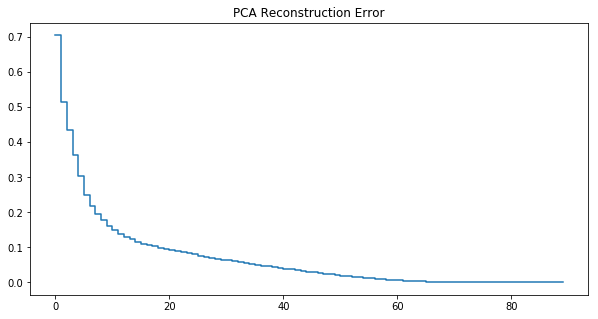

In [52]:
plt.plot(1 - varianceExplained, drawstyle = 'steps-post')
plt.title('PCA Reconstruction Error');

In [53]:
n_factors = ((1 - varianceExplained) > 0.10).sum()
print("Number of factors with 10% of reonstraction Error: ", n_factors)

Number of factors with 10% of reonstraction Error:  18


#### 3.2.1 Apache Spark Implementation

In [54]:
#Apache Spark API
pca = PCA(k = n_factors, inputCol="features", outputCol="pca_features")

In [55]:
labeledDataFrame

DataFrame[label: bigint, features: vector]

In [56]:
pcaModel = pca.fit(labeledDataFrame)

In [57]:
pcaDataFrame = pcaModel.transform(labeledDataFrame).drop("features")

In [58]:
pcaDataFrame.limit(10).toPandas()

,label,pca_features
0,7,"[0.4092095986138343, 0.5622203899840927, 0.260..."
1,7,"[0.8329281152434733, -0.47042369046326027, -0...."
2,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."
3,7,"[0.7088903082280973, 1.1814404139144132, -0.04..."
4,7,"[0.7088903082883998, 1.1814404139194505, -0.04..."
5,0,"[-0.6024765280183482, 0.4465725742426462, -1.0..."
6,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."
7,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."
8,0,"[-0.7843197336149491, 0.5127359042114004, 0.39..."
9,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."


### 3.4 Sampling

In [59]:
# Sampling with replacement with the 30% of data
trainingData = pcaDataFrame.sample(withReplacement = True, fraction = 0.30).cache()

In [60]:
trainingData.limit(10).toPandas()

,label,pca_features
0,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."
1,0,"[-0.6024765280183482, 0.4465725742426462, -1.0..."
2,0,"[-1.0560852902674833, 0.3571853239675803, -0.1..."
3,5,"[0.40920959861592165, 0.562220389984151, 0.260..."
4,0,"[-0.7889080183075051, 0.5127239077243559, 0.39..."
5,7,"[0.7088903082864305, 1.1814404139193107, -0.04..."
6,7,"[0.7088903082802549, 1.1814404139187982, -0.04..."
7,7,"[0.4298680447060765, 0.5635942167611052, 0.256..."
8,7,"[0.7088903082842414, 1.1814404139191432, -0.04..."
9,7,"[0.9281746855585047, -0.6696829350687787, -0.2..."


## 4. Modeling

## 4.1 Cluster metrics

Two desirable objectives for any cluster assignment:
* **homogeneity**: each cluster contains only members of a single class.
* **completeness**: all members of a given class are assigned to the same cluster.

The main cluster metrics are:

* **Homogeneity Score**: A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

* **Completeness Score**: A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

* **V measure Scores** : the harmonic mean between homogeneity and completeness: v = 2 * (homogeneity * completeness) / (homogeneity + completeness)
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

## 4.2 K-means

* *k:* number of desired clusters.
* *maxIter:* maximum number of iterations to run.
* *initMode:* specifies either random initialization or initialization via k-means.
* *initSteps:* determines the number of steps in the k-means|| algorithm.
* *tol:* determines the distance threshold within which we consider k-means to have converged.
* initialModel:* an optional set of cluster centers used for initialization. If this parameter is supplied, only one run is performed.

In [61]:
from pyspark.ml.clustering import KMeans

### 4.2.1 Random centroid initialization (5 clusters)

In [62]:
kmeans = KMeans(k = 5, initMode = "random", initSteps = 10, 
                featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )

In [63]:
model = kmeans.fit(trainingData)

In [64]:
clusterCenters = model.clusterCenters()

In [65]:
pd.DataFrame(clusterCenters)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.757586,0.486864,-0.024543,0.236083,0.092630,0.327780,-0.031567,0.082643,0.019845,-0.180902,0.102081,-0.087065,-0.287423,0.012281,0.169677,-0.058425,0.030965,0.006221
1,0.429868,0.563594,0.256109,-0.087637,-0.258998,1.104994,0.574520,0.169472,0.054447,-0.304644,-0.005063,-0.031381,-0.274040,0.009551,0.158216,-0.015986,0.016967,-0.000656
2,0.602329,1.064928,-0.035361,0.285244,0.132903,0.401692,-0.120976,0.094836,0.027109,-0.201088,0.122660,-0.098018,-0.295401,0.012323,0.165060,-0.047765,0.025180,0.003227
3,0.806031,-0.470949,0.002122,0.243864,0.231495,0.227371,-0.023218,0.082238,0.039669,-0.217607,0.088624,-0.073499,-0.271994,0.012088,0.152576,-0.042142,0.024540,0.003164
4,-0.591070,0.532439,0.375857,0.134199,-0.312370,0.649374,0.632214,0.175688,0.040192,-0.294012,-0.217265,0.108668,-0.054265,-0.040382,0.144479,0.193079,-0.083616,-0.045564


In [66]:
predictedData = model.transform(pcaDataFrame)
predictedData.cache()

DataFrame[label: bigint, pca_features: vector, prediction: int]

In [67]:
predictedData.limit(10).toPandas()

,label,pca_features,prediction
0,7,"[0.4092095986138343, 0.5622203899840927, 0.260...",2
1,7,"[0.8329281152434733, -0.47042369046326027, -0....",3
2,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",0
3,7,"[0.7088903082280973, 1.1814404139144132, -0.04...",2
4,7,"[0.7088903082883998, 1.1814404139194505, -0.04...",2
5,0,"[-0.6024765280183482, 0.4465725742426462, -1.0...",0
6,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",0
7,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",0
8,0,"[-0.7843197336149491, 0.5127359042114004, 0.39...",0
9,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",0


In [68]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(row, centers):
    center = centers[row["prediction"]]
    point = row["pca_features"]
    return np.sqrt(np.sum([x**2 for x in (point - center)]))

In [69]:
print("KMeans error:" , predictedData.rdd.map(lambda row: error(row, clusterCenters)).reduce(lambda a,b : a+b))

KMeans error: 89915.78043535253


In [70]:
kmeansMeasures = predictedData.groupBy(predictedData.label, predictedData.prediction).count().toPandas()

In [71]:
#completeness (all members of a given class are assigned to the same cluster)
print("Completeness:" , 1.0*np.sum(kmeansMeasures.groupby("label")["count"].max())/np.sum(kmeansMeasures["count"]))

Completeness: 0.8066411056337469


In [72]:
kmeansMeasures[kmeansMeasures.label==3]

,label,prediction,count
16,3,1,2
19,3,0,2900
29,3,3,5
40,3,2,11
46,3,4,13


In [73]:
#homogeneity (each cluster contains only members of a single class.)
print("Homogeneity:", 1.0*np.sum(kmeansMeasures.groupby("prediction")["count"].max())/np.sum(kmeansMeasures["count"]))

Homogeneity: 0.8525636445905075


In [74]:
kmeansMeasures[kmeansMeasures.prediction==2]

,label,prediction,count
0,7,2,45767
1,12,2,51
2,10,2,29
4,14,2,6
7,9,2,3
10,21,2,9
12,11,2,7
14,6,2,2
20,13,2,20
22,16,2,2


### 4.2.2 Finding the optimal number of clusters

In [75]:
def kmeansClusterMeasures(n_Clusters, dataFrame):
    #build a kmean cluster from dataFrame and with n_Clusters centroides
    #and returns the error, completeness and homogeneity of kmean's model

    trainingData, testData = dataFrame.randomSplit([70.0, 30.0])
    
    kmeans = KMeans(k = n_Clusters, initMode = "random", initSteps = 10, 
                    featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )
    model = kmeans.fit(trainingData)
    centers = model.clusterCenters()
    
    predictedData = model.transform(testData)
    predictedData.cache()
    
    errorKmeans =  predictedData.rdd.map(lambda row: error(row, centers)).reduce(lambda a,b : a+b)
    
    kmeansMeasures = predictedData.groupBy(predictedData.label, predictedData.prediction).count().toPandas()
    completeness = 1.0*np.sum(kmeansMeasures.groupby("label")["count"].max())/np.sum(kmeansMeasures["count"])
    homogeneity = 1.0*np.sum(kmeansMeasures.groupby("prediction")["count"].max())/np.sum(kmeansMeasures["count"])
    
    
    return n_Clusters, errorKmeans, completeness, homogeneity

In [76]:
def findBestCluster(minNClusters, maxNClusters, dataFrame):
    nClusters = np.arange(minNClusters, maxNClusters+1)
    kmeansMeasures = [kmeansClusterMeasures(n, trainingData) for n in nClusters]
    return pd.DataFrame(kmeansMeasures, 
                        columns = ["nClusters", "error", "completeness", "homogeneity"],
                       index = nClusters)

In [77]:
%%time
print(kmeansClusterMeasures(5, trainingData))

(5, 8174.145546168689, 0.7813405956250549, 0.847052622331547)
CPU times: user 20 ms, sys: 40 ms, total: 60 ms
Wall time: 1.9 s


In [78]:
%%time
kmeansMeasures = findBestCluster(4, 20, trainingData)

CPU times: user 700 ms, sys: 370 ms, total: 1.07 s
Wall time: 24.4 s


In [79]:
kmeansMeasures

,nClusters,error,completeness,homogeneity
4,4,8428.358478,0.859536,0.868391
5,5,7142.595366,0.691464,0.834144
6,6,7058.450973,0.605874,0.852898
7,7,6513.554009,0.614778,0.831028
8,8,7014.085011,0.615011,0.852892
9,9,5500.978013,0.554041,0.850942
10,10,5553.153946,0.534088,0.825568
11,11,5717.652643,0.552454,0.829994
12,12,4714.841506,0.648390,0.849197
13,13,3969.044443,0.537512,0.870262


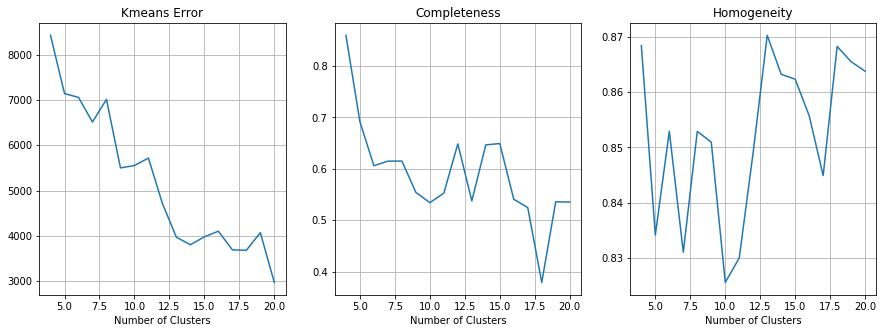

In [80]:
fig, axes = plt.subplots(1, 3)
kmeansMeasures.error.plot(ax=axes[0],title="Kmeans Error", grid = True, figsize=(15,5))
axes[0].set_xlabel("Number of Clusters")
kmeansMeasures.completeness.plot(ax=axes[1],title="Completeness", grid = True)
axes[1].set_xlabel("Number of Clusters")
kmeansMeasures.homogeneity.plot(ax=axes[2],title="Homogeneity", grid = True)
axes[2].set_xlabel("Number of Clusters");

#### Create the clusters with  11 centroids

In [81]:
%%time
kmeans = KMeans(k = 11, initMode = "random", initSteps = 10, 
                featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )
model = kmeans.fit(trainingData)
clusterCenters = model.clusterCenters()

CPU times: user 10 ms, sys: 20 ms, total: 30 ms
Wall time: 353 ms


In [82]:
%%time
predictedData = model.transform(pcaDataFrame)
predictedData.cache()

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 30 ms


In [83]:
predictedData.limit(5).toPandas()

,label,pca_features,prediction
0,7,"[0.4092095986138343, 0.5622203899840927, 0.260...",0
1,7,"[0.8329281152434733, -0.47042369046326027, -0....",9
2,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",1
3,7,"[0.7088903082280973, 1.1814404139144132, -0.04...",3
4,7,"[0.7088903082883998, 1.1814404139194505, -0.04...",3


#### Visualize the results on PCA-reduced data

In [84]:
from pyspark.ml.feature import PCA
from pyspark.sql import Row

In [85]:
pca = PCA(k=2, inputCol="pca_features", outputCol="pca_2D")
modelPCA = pca.fit(predictedData)
projectedDT = modelPCA.transform(predictedData)

In [86]:
projectedDT.limit(5).toPandas()

,label,pca_features,prediction,pca_2D
0,7,"[0.4092095986138343, 0.5622203899840927, 0.260...",0,"[-0.40920959861384437, -0.5622203899840804]"
1,7,"[0.8329281152434733, -0.47042369046326027, -0....",9,"[-0.8329281152434668, 0.47042369046329163]"
2,0,"[-1.0560852902674833, 0.3571853239675803, -0.1...",1,"[1.0560852902674782, -0.3571853239676019]"
3,7,"[0.7088903082280973, 1.1814404139144132, -0.04...",3,"[-0.7088903082281082, -1.1814404139144088]"
4,7,"[0.7088903082883998, 1.1814404139194505, -0.04...",3,"[-0.7088903082884107, -1.181440413919446]"


In [87]:
clusterCentersDF = sc.parallelize(
    [Row(n, DenseVector(cluster.tolist())) for n, cluster in zip(range(len(clusterCenters)), clusterCenters)]
).toDF(["prediction", "pca_features"])

In [88]:
clusterCentersDF.toPandas()

,prediction,pca_features
0,0,"[0.4026409099403107, 0.5622227993257025, 0.258..."
1,1,"[-0.9105682216744551, 0.38018471344108384, -0...."
2,2,"[-0.010178714860505292, 1.2178732984343341, -0..."
3,3,"[0.7088902992093498, 1.1814403979032233, -0.04..."
4,4,"[0.7088734696745649, 1.1814105489224351, -0.04..."
5,5,"[-0.35858111445538793, 0.533592965758136, 0.29..."
6,6,"[-0.7687117646101417, 0.5528897178556963, 0.39..."
7,7,"[0.41790121256774043, 0.5636212658469348, 0.25..."
8,8,"[0.3697032614580684, 0.5535370623329384, 0.146..."
9,9,"[0.806030858459588, -0.4709487135960153, 0.002..."


In [89]:
clusterCenters2D = modelPCA.transform(clusterCentersDF)

In [90]:
centers2D = clusterCenters2D.rdd.map(lambda row: (row["prediction"], row["pca_2D"]))\
                            .map(lambda v: Row(prediction = v[0], x1 = v[1].values.tolist()[0],\
                                                     x2 = v[1].values.tolist()[1]))\
                            .toDF().toPandas()

In [91]:
n_points = 10000
points2D = projectedDT.limit(n_points).rdd\
                      .map(lambda row: (row["label"], row["prediction"], row["pca_2D"]))\
                      .map(lambda v: Row(label = v[0], 
                                                prediction = v[1], 
                                                x1 = v[2].values.tolist()[0], 
                                                x2 = v[2].values.tolist()[1]))\
                       .toDF().toPandas()

In [92]:
points2D.head()

,label,prediction,x1,x2
0,7,0,-0.409210,-0.562220
1,7,9,-0.832928,0.470424
2,0,1,1.056085,-0.357185
3,7,3,-0.708890,-1.181440
4,7,3,-0.708890,-1.181440


In [93]:
# set colors

from matplotlib import colors
import six
colors_ = list(six.iteritems(colors.cnames))

# Add the single letter colors.
for name, rgb in six.iteritems(colors.ColorConverter.colors):
    hex_ = colors.rgb2hex(rgb)
    colors_.append((name, hex_))

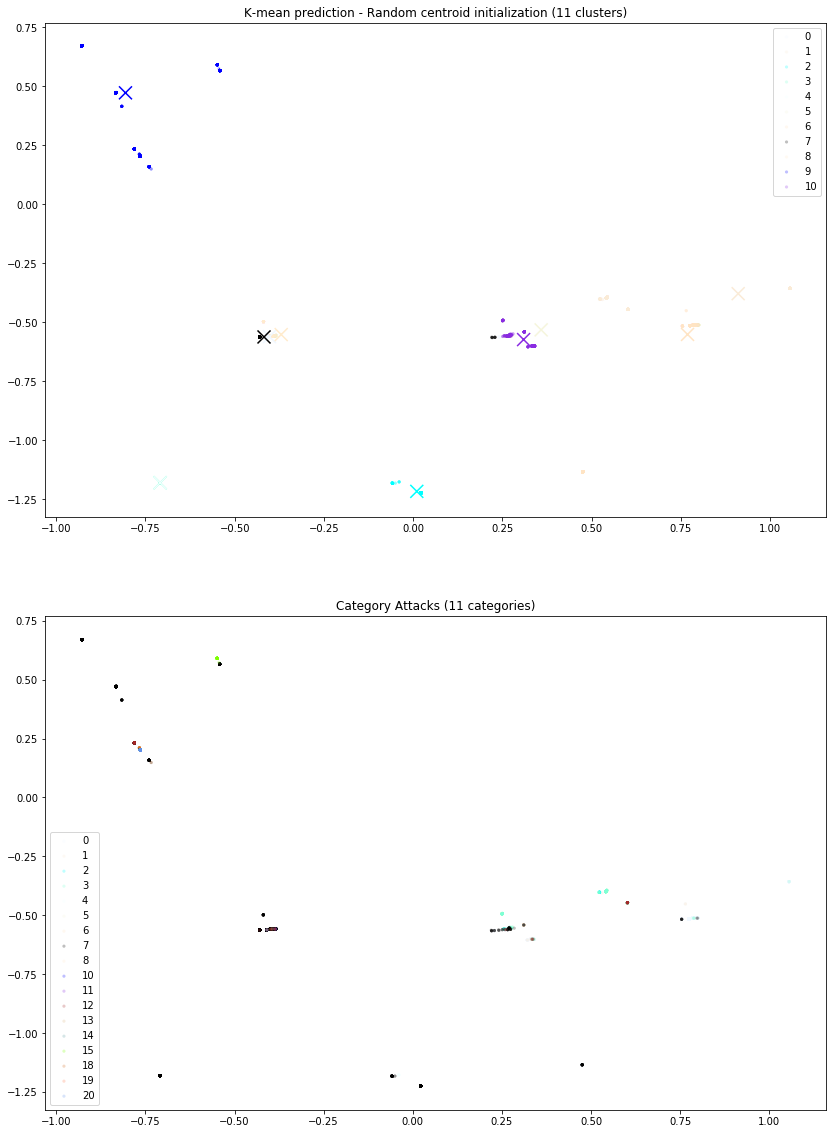

In [94]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 20) )
ax1, ax2 = axes.ravel()

# Plot the clusters
for i, color in zip(set(points2D.prediction), colors_):
    idx = np.where(points2D.prediction == i)
    ax1.scatter(points2D.values[idx, 2], points2D.values[idx, 3], c=color, s = 10, label=i, alpha = 0.25, edgecolors='none')
    # Plot the centroids as X
    ax1.scatter(centers2D.values[i, 1], centers2D.values[i, 2],
            marker='x', s=169, linewidths=3,
            color=color, zorder=10)
ax1.set_title('K-mean prediction - Random centroid initialization (11 clusters)')
ax1.legend()



#Plot the category values
for i, color in zip(set(points2D.label), colors_):
    idx = np.where(points2D.label == i)
    ax2.scatter(points2D.values[idx, 2], points2D.values[idx, 3], c=color, s = 10, label=i, alpha = 0.25, edgecolors='none')
    
ax2.set_title('Category Attacks (11 categories)')
ax2.legend();